## Setup

In [1]:
# Web Scraping
import requests
import bs4
from urllib.parse import urljoin

# Data Manipulation
import numpy as np
import pandas as pd

from pandas import IndexSlice as idx

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [2]:
# Current latest report URL
REPORT_URL = 'https://proverbot9001.ucsd.edu/reports/2024-01-26T19d27d24-0700+a13e20f06b2535d9abd20853749b0709b280e054/'

# Get the report information and load into BS4
r = requests.get(REPORT_URL)
index_soup = bs4.BeautifulSoup(r.content)

In [3]:
# Grab each row in the table (without the header or the total)
table_rows = index_soup.table.find_all('tr')[1:-1]

# Associate each filename with a URL for its data
file_urls = [row.a['href'] for row in table_rows]

# Turn each link into a soup
file_soups = [(href.removesuffix('.html'), bs4.BeautifulSoup(requests.get(urljoin(REPORT_URL, href)).content)) for href in file_urls]

In [4]:
def process_file_soup(fname: str, soup: bs4.BeautifulSoup):
    # Grab all theorems and proofs
    relevant_elems = soup.select('button.collapsible, div.region')

    # Separate into alternating theorems and proofs, and check that each theorem (button) is followed by a theorem (div)
    thm_elems = relevant_elems[::2]
    prf_elems = relevant_elems[1::2]
    assert(all(x.name == 'button' for x in thm_elems))
    assert(all(x.name == 'div' for x in prf_elems))

    # Get all theorems, along with whether Proverbot succeeded
    theorems = [(thm.code.text, thm['class'][1]) for thm in thm_elems]
    theorems_df = pd.DataFrame(data=theorems, columns=['theorem', 'result'])

    # Get all proofs, and separate into the predicted proof and the original proof
    pred_orig_proofs = [(prf.find(class_='predicted').find_all('span'), prf.find(class_='original').find_all('span')) for prf in prf_elems]

    # For each such proof, separate out only the text and subgoals
    proofs = [([(x.text, x['data-subgoals']) for x in pred], [(x.text, x['data-subgoals']) for x in orig]) for pred, orig in pred_orig_proofs]

    # Create a DataFrame to hold these
    proofs_df = pd.DataFrame(proofs, columns=['pred', 'orig'])

    # Melt and reset to get theorem index and source as columns
    proofs_df = pd.melt(proofs_df, value_vars=['pred', 'orig'], var_name='source', ignore_index=False).reset_index(names='theorem')

    # Explode to turn the lists into rows, groupby cumulative count to give line numbers
    proofs_df = proofs_df.explode('value').reset_index(names='line')
    proofs_df['line'] = proofs_df.groupby('line').cumcount()

    # Combine theorem, source, and line number into our final multi-index
    proofs_df = proofs_df.set_index(['theorem', 'source', 'line']).sort_index()

    # Separate our combined value column into tactics and subgoals, then delete the redundant column
    proofs_df[['tactic', 'subgoals']] = pd.DataFrame(proofs_df['value'].to_list(), index=proofs_df.index)
    del proofs_df['value']

    # Return both with fname for easy unzipping
    return [(fname, theorems_df), (fname, proofs_df)]

In [5]:
full_data = [process_file_soup(fname, soup) for fname, soup in file_soups]

# Unzip our data (organized by proofs vs theorems instead of by filename primarily)
unzip_theorems, unzip_proofs = zip(*full_data)

theorem_df = pd.concat(dict(unzip_theorems))
theorem_df.index = theorem_df.index.set_names(['fname', 'index'])

# We also remove skipped theorems, as Proverbot pretends they do not exist
raw_proof_df = pd.concat(dict(unzip_proofs)).loc[theorem_df['result'] != 'skipped']
raw_proof_df.index = raw_proof_df.index.set_names({None: 'fname'})

In [6]:
theorem_df

theorem result
fname      index                                                          
Globalenvs 0      (** Auxiliary function for initialization of g...   okay
           1      Theorem shift_symbol_address:\n  forall ge id ...   good
           2      Theorem shift_symbol_address_32:\n  forall ge ...   good
           3      Theorem shift_symbol_address_64:\n  forall ge ...   good
           4                                       Next Obligation.   okay
...                                                             ...    ...
Mult_error 4      Lemma F2R_ge: forall (y:float beta),\n   (F2R ...   okay
           5      Theorem mult_error_FLT_ge_bpow :\n  forall x y...   okay
           6      Lemma mult_bpow_exact_FLT :\n  forall x e,\n  ...   okay
Wfsimpl    0      Theorem unroll_Fix:\n  forall x, Fix x = F (fu...    bad
           1      Theorem unroll_Fixm:\n  forall x, Fixm x = F (...   good

[516 rows x 2 columns]

In [7]:
raw_proof_df

tactic  \
fname      theorem source line                            
Globalenvs 0       orig   0                      Proof.   
                          1                     intros.   
                          2                        red.   
                          3                      omega.   
                          4     apply Zwf_well_founded.   
...                                                 ...   
Wfsimpl    1       orig   9                        Qed.   
                   pred   0                      Proof.   
                          1                     intros.   
                          2           apply unroll_Fix.   
                          3                        Qed.   

                                                                         subgoals  
fname      theorem source line                                                     
Globalenvs 0       orig   0     (("forall (m : Mem.mem) (b : block) (p n : Z) ...  
                          1     (("forall (m : Mem.mem) (b : block) (p n : Z) ...  
                          2     (("Zwf Z0 (Z.sub n (Zpos xH)) n", ("teq0 : eq ...  
                          3     (("and (Z.le Z0 n) (Z.lt (Z.sub n (Zpos xH)) n...  
                          4                     (("well_founded (Zwf Z0)", ("")))  
...                                                                           ...  
Wfsimpl    1       orig   9                                                    ()  
                   pred   0     (("forall x : A,\neq (Fixm x)\n  (F (fun (y : ...  
                          1     (("forall x : A,\neq (Fixm x)\n  (F (fun (y : ...  
                          2     (("eq (Fixm x)\n  (F (fun (y : A) (_ : lt (mea...  
                          3                                                    ()  

[9604 rows x 2 columns]

We have two `DataFrame`s that describe the data here. The `theorem_df` frame contains every theorem in the used CompCert dataset, along with what file it is in, its index in the file, and whether or not Proverbot9001 succeeded. The `raw_proof_df` frame contains every line from every proof, both the original and the predicted proofs, along with the proof state in the form of subgoals. These are both indexed by filename and theorem number, and the proof frame is also indexed by whether it is original or predicted, and what line in the proof it is. 

These frames are multi-indexed in order to enforce uniqueness of index and avoid large amounts of "and" conditions in filters. Sometimes this requires advanced indexing; for example:

In [8]:
# Show all theorems in the 'Globalenvs' file
theorem_df.loc[idx['Globalenvs', :], :]

theorem result
fname      index                                                          
Globalenvs 0      (** Auxiliary function for initialization of g...   okay
           1      Theorem shift_symbol_address:\n  forall ge id ...   good
           2      Theorem shift_symbol_address_32:\n  forall ge ...   good
           3      Theorem shift_symbol_address_64:\n  forall ge ...   good
           4                                       Next Obligation.   okay
...                                                             ...    ...
           107    Theorem find_funct_ptr_transf:\n  forall b f,\...   okay
           108    Theorem find_funct_transf:\n  forall v f,\n  f...   okay
           109    Theorem find_symbol_transf:\n  forall (s : ide...   okay
           110    Theorem senv_transf:\n  Senv.equiv (to_senv (g...    bad
           111    Theorem init_mem_transf:\n  forall m, init_mem...   okay

[112 rows x 2 columns]

In [9]:
# Show all predicted proofs that Proverbot did not fail/give up on
raw_proof_df.loc[theorem_df['result'] == 'good'].loc[idx[:, :, 'pred', :], :]

tactic  \
fname              theorem source line                           
Globalenvs         1       pred   0                     Proof.   
                                  1                    intros.   
                                  2     unfold symbol_address.   
                                  3        unfold find_symbol.   
                                  4               destruct ge.   
...                                                        ...   
Validator_complete 2       pred   7                       Qed.   
Wfsimpl            1       pred   0                     Proof.   
                                  1                    intros.   
                                  2          apply unroll_Fix.   
                                  3                       Qed.   

                                                                                 subgoals  
fname              theorem source line                                                     
Globalenvs         1       pred   0     (("forall (ge : t) (id : ident) (ofs delta : P...  
                                  1     (("forall (ge : t) (id : ident) (ofs delta : P...  
                                  2     (("eq (symbol_address ge id (Ptrofs.add ofs de...  
                                  3     (("eq\n  match find_symbol ge id with\n  | Som...  
                                  4     (("eq\n  match\n    (let\n       (find_symbol,...  
...                                                                                   ...  
Validator_complete 2       pred   7                                                    ()  
Wfsimpl            1       pred   0     (("forall x : A,\neq (Fixm x)\n  (F (fun (y : ...  
                                  1     (("forall x : A,\neq (Fixm x)\n  (F (fun (y : ...  
                                  2     (("eq (Fixm x)\n  (F (fun (y : A) (_ : lt (mea...  
                                  3                                                    ()  

[1260 rows x 2 columns]

### Data Cleaning

There are some proofs for which there is no predicted output at all. These show up as NaNs, so we remove them to allow more operations on the `DataFrame`.

In [10]:
raw_proof_df.loc[raw_proof_df['tactic'].isna()]

tactic subgoals
fname         theorem source line                
SelectOpproof 5       pred   0       NaN     None
Cop           10      pred   0       NaN     None
              11      pred   0       NaN     None
              14      pred   0       NaN     None
RTL           5       pred   0       NaN     None
              6       pred   0       NaN     None

In [11]:
# With NAs removed, we can now interpret this DataFrame as all strings
str_proof_df = raw_proof_df.dropna(how='any').astype(str)

We will now remove the first and last line of each proof, since it contains no interesting information. This will also incidentally remove all `Proof. Admitted.` "proofs" created when Proverbot failed. 

There are some original proofs that do not start with some version of the `Proof` command. These are primarily due to the `Next Obligation.` command, so we will make sure not to remove the first line of these proofs.

In [12]:
missing_start = str_proof_df.loc[idx[:, :, :, 0], :].loc[~str_proof_df['tactic'].str.startswith('Proof')].index

str_proof_df.loc[missing_start]

tactic  \
fname      theorem source line                               
Globalenvs 4       orig   0       destruct ge; simpl in *.   
           5       orig   0       destruct ge; simpl in *.   
           6       orig   0       destruct ge; simpl in *.   
           8       orig   0     rewrite PTree.gempty in H.   
           9       orig   0     rewrite PTree.gempty in H.   
           10      orig   0     rewrite PTree.gempty in H.   
Cop        16      orig   0                        intros.   

                                                                         subgoals  
fname      theorem source line                                                     
Globalenvs 4       orig   0     (("Plt b (Pos.succ (genv_next ge))", ("H : eq\...  
           5       orig   0     (("Plt b (Pos.succ (genv_next ge))", ("H : eq\...  
           6       orig   0     (("eq id1 id2", ("H0 : eq\n  (PTree.get id2\n ...  
           8       orig   0     (("Plt b xH", ("H : eq (PTree.get id (PTree.em...  
           9       orig   0     (("Plt b xH", ("H : eq (PTree.get b (PTree.emp...  
           10      orig   0     (("eq id1 id2", ("H0 : eq (PTree.get id2 (PTre...  
Cop        16      orig   0     (("forall (v : val) (t : type) (m : Mem.mem),\...

There are no interesting proofs that do not end in one of the normal endings for a proof (Qed, Defined, or Admitted). The only examples are proofs done in one line (although this is [discouraged](https://coq.inria.fr/doc/V8.19.0/refman/proofs/writing-proofs/proof-mode.html#coq:cmd.Proof-%60term%60) by Coq's manual), and proofs with a comment before the last line. For the former example, these will be transformed into their equivalent, `exact <term>`.

In [13]:
# Get the last line of each proof by looking at the max line number of each proof.
end_lines = str_proof_df.reset_index(level='line')['line'].groupby(level=['fname', 'theorem', 'source']).max()

# Convert this maximum back to an index (line)
end_index = end_lines.to_frame().reset_index().set_index(['fname', 'theorem', 'source', 'line']).sort_index().index

# Show all end tactics that aren't Qed, Defined, or Admitted
str_proof_df.loc[end_index].loc[idx[:, :, 'orig', :], :].loc[~str_proof_df['tactic'].isin(['Qed.', 'Admitted.', 'Defined.'])]

tactic  \
fname          theorem source line                                                      
Globalenvs     92      orig   0                    Proof (mge_defs globalenvs_match).   
Locations      29      orig   0                                   Proof (@eq_refl t).   
               30      orig   0                                    Proof (@eq_sym t).   
               31      orig   0                                  Proof (@eq_trans t).   
Parmov         0       orig   0                      Proof (@extensionality reg val).   
SelectOpproof  1       orig   15    (*rewrite eval_Olea_ptr. apply eval_addressing...   
               2       orig   4     (*rewrite eval_Olea_ptr. apply eval_addressing...   
Selectionproof 7       orig   0                Proof (Genv.find_symbol_match TRANSF).   
               8       orig   0                       Proof (Genv.senv_match TRANSF).   
               9       orig   0             Proof (Genv.find_funct_ptr_match TRANSF).   

                                                                             subgoals  
fname          theorem source line                                                     
Globalenvs     92      orig   0     (("forall b : block,\noption_rel (match_globde...  
Locations      29      orig   0                      (("forall x : t, eq x x", ("")))  
               30      orig   0     (("forall (x y : t) (_ : eq x y), eq y x", ("")))  
               31      orig   0     (("forall (x y z : t) (_ : eq x y) (_ : eq y z...  
Parmov         0       orig   0     (("forall (e1 e2 : env) (_ : forall r : reg, e...  
SelectOpproof  1       orig   15                                                   ()  
               2       orig   4                                                    ()  
Selectionproof 7       orig   0     (("forall s : ident, eq (Genv.find_symbol tge ...  
               8       orig   0     (("Senv.equiv ge tge", ("TRANSF : match_prog p...  
               9       orig   0     (("forall (b : block) (f : Cminor.fundef)\n  (...

We now remove the first and last lines of every proof, except for the proofs requiring special treatment (the single line proofs and the ones that don't start with `Proof`). This does lose a small amount of information if there are proofs that contain `Proof with <tactic>.`, since it will become unknown what the `...` refers to, but this can always be recovered, and is very rare.

In [14]:
# Get full proofs where the first line is not Proof or some variant thereof
missing_start_full = str_proof_df.loc[str_proof_df.index.isin(missing_start.droplevel('line'))].index

# Combine the 7 proofs without a "Proof" or other similar no-op tactic to start
# and the 8 proofs that are exactly 1 line.
unusual_index = missing_start_full.union(end_index[end_lines == 0])

# A DataFrame of all the proofs that don't need special treatment
normal_index = str_proof_df.index.difference(unusual_index)
normal_df = str_proof_df.loc[normal_index]

# Indexes the start and end of every "normal" proof
normal_start_index = normal_df.loc[idx[:, :, :, 0], :].index
normal_end_index = end_index.difference(unusual_index)
to_remove_index = normal_start_index.union(normal_end_index)

# Remove the first and last lines, then decrement line count by one (zero indexing)
fixed_normal_df = normal_df.drop(index=to_remove_index).reset_index()
fixed_normal_df['line'] = fixed_normal_df['line'] - 1

# Find all of the proofs of the form `Proof term.`
one_line_df = str_proof_df.loc[end_index[end_lines == 0]]
# Since `Proof term.` is the same as `exact term. Qed.`, and we are removing `Qed.`, we can just replace `Proof` with `exact`.
one_line_df['tactic'] = one_line_df['tactic'].str.replace("Proof", "exact")

proof_df = pd.concat((
    one_line_df,
    fixed_normal_df.set_index(['fname', 'theorem', 'source', 'line']),
    str_proof_df.loc[missing_start_full].drop(index=end_index.intersection(missing_start_full))
)).sort_index()
assert(proof_df.index.is_unique)

Finally, we create a couple of `DataFrames` that are ready to have analyses run on them.

In [15]:
# `proof_df` contains all proofs with any useful data; this is all original proofs, along with any predicted proof with something generated
# Contains all 508 + 133 original and predicted proofs, respectively

# Mirrored DataFrame; it contains a proof if and only if there is both an original proof and a predicted proof in proof_df
# Since there are no proofs in the predicted set but not in the original set, this means it contains only the proofs with generated output
# This makes comparisons more apples-to-apples, but may bias towards easier proofs
useful_thms = proof_df.loc[idx[:, :, 'pred', :], :].reset_index(['source', 'line']).index.unique()
mirror_proof_df = proof_df.loc[proof_df.index.isin(useful_thms)]

## Analysis

We verify on the next line that each line in our proofs contains exactly one tactic (or a bullet). There are some lines that certainly do more than one thing, however, since the `;` operator allows two or more tactics to be squished together. Whether these should be counted as separate lines is arguable, since the `;` operator also applies the second tactic on each subgoal generated, which is different than the usual behavior. Because it is difficult to estimate how many lines this tactical saves (since it could be anywhere from 1-100 lines depending on the number of subgoals), we leave it as is here, but note that it is one of the reasons for the shorter line counts.

In [16]:
a = proof_df.tactic.str.count('[-+*.]$')
assert(len(a[a!=1]) == 0)

### Proof Line Counts

Note that there is only one proof (to `Selectionproof` theorem 56) that exceeds 110 lines. We will remove this proof, as at 292 lines it makes reading the data impossible.

In [17]:
lens = (proof_df.reset_index('line')['line'].groupby(['fname', 'theorem', 'source']).max() + 1).reset_index()

lens[lens.line > 100]

,fname,theorem,source,line
114,Globalenvs,63,orig,106
400,SelectOpproof,5,orig,102
547,Selectionproof,56,orig,292


We now compare the line counts of the proofs in the dataset.

In [18]:
def calc_line_count(df: pd.DataFrame):
    # Length of each proof is the last line index, plus 1 due to 0 indexing
    return df.reset_index('line')['line'].groupby(['fname', 'theorem', 'source']).max() + 1

def plot_line_count(df: pd.DataFrame, ax = None, **kwargs):
    lens = calc_line_count(df).reset_index()
    # Normalize separately since the number of items in the two subsets are not the same
    norm_lens = pd.concat([lens[lens.source == 'orig'].value_counts(normalize=True), lens[lens.source == 'pred'].value_counts(normalize=True)]).reset_index()

    ax = sns.histplot(data=norm_lens, x='line', weights='proportion', hue='source', discrete=True, ax=ax)
    ax.set(xlabel='Line Count', ylabel='Proportion', **kwargs);

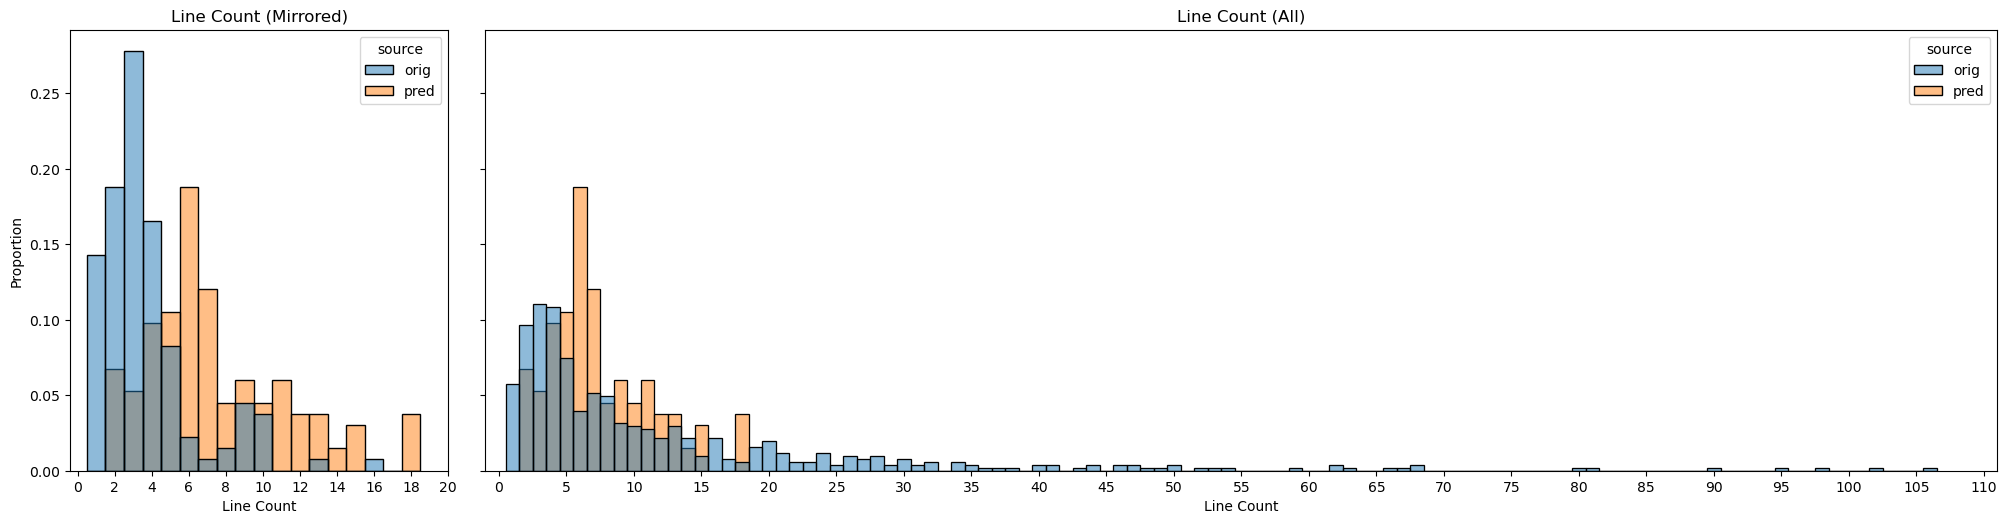

In [19]:
# Remove the 300 line proof so that we can see what is happening
acceptable = proof_df.index.difference(proof_df.loc[idx['Selectionproof', 56, 'orig', :], :].index)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20, 5), width_ratios=[1, 4])
fig.tight_layout()

plot_line_count(mirror_proof_df,                 ax=axs[0], xticks=range(0, 22, 2),  title='Line Count (Mirrored)')
plot_line_count(proof_df.loc[acceptable], ax=axs[1], xticks=range(0, 111, 5), title='Line Count (All)',    xlim=(-1, 111))

In [20]:
# Average of solutions by Proverbot:
calc_line_count(mirror_proof_df.loc[idx[:, :, 'pred'], :]).agg(['mean', 'median'])

mean      7.473684
median    6.000000
Name: line, dtype: float64

In [21]:
# Average of original proofs also solved by Proverbot:
calc_line_count(mirror_proof_df.loc[idx[:, :, 'orig'], :]).agg(['mean', 'median'])

mean      3.736842
median    3.000000
Name: line, dtype: float64

In [22]:
# Average of all original proofs:
calc_line_count(proof_df.loc[idx[:, :, 'orig'], :]).agg(['mean', 'median'])

mean      13.005906
median     7.000000
Name: line, dtype: float64

With the averages above, we see that while the original proofs are on average longer than the generated proofs (around 8 lines, though heavily skewed), when looking only at the mirrored dataset, the original proofs are shorter (closer to 3-4 lines) than Proverbot's predictions (on average 6-7 lines).

To see how Proverbot compares on each theorem, we look at the differences in line counts between the proofs that were generated and the original proofs.

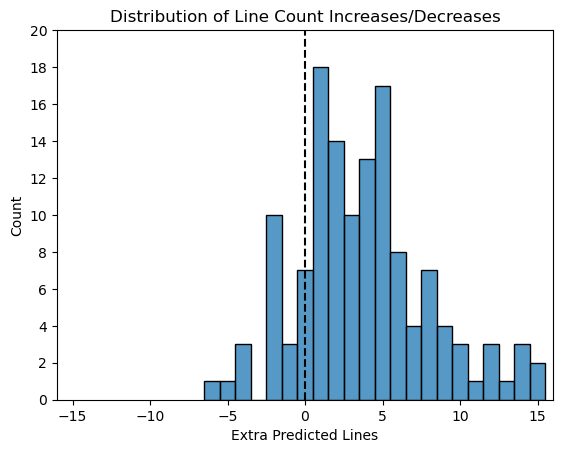

In [23]:
lens = calc_line_count(mirror_proof_df)
ax = sns.histplot(lens.loc[idx[:, :, 'pred']] - lens.loc[idx[:, :, 'orig']], discrete=True)
ax.set(xlim=[-16, 16], yticks=range(0, 21, 2), xlabel="Extra Predicted Lines", title="Distribution of Line Count Increases/Decreases")
ax.axvline(0, color='k', linestyle='--');

In [24]:
(lens.loc[idx[:, :, 'pred']] - lens.loc[idx[:, :, 'orig']]).agg(['mean', 'median'])

mean      3.736842
median    3.000000
Name: line, dtype: float64

Indeed, we see that most Proverbot proofs use around 3-4 extra lines over the original, although a small selection do better than the original (negative values).

### Tactic Frequency

In [25]:
# Strip comments
no_comments = proof_df.tactic.str.replace(r'\(\*.*?\*\)', '', regex=True)
# Strip goal selectors
no_selectors = no_comments.str.replace(r'^\d+:', '', regex=True)
# Delete Ltac declarations
no_ltac = no_selectors.drop(index=no_selectors[no_selectors.str.startswith('Ltac')].index)

# Get all tactics, including those combined with ;
tactic_invocations = no_ltac.str.split(';').explode().str.strip()
# Remove subgoals handled with [ | ] syntax, as this is so rare it is not worth handling specially.
no_brackets = tactic_invocations.drop(index=tactic_invocations[tactic_invocations.str.startswith('[')].index)

tactics = no_brackets.str.split(r'[ .()=]', n=1, expand=True)[0]

tactics.value_counts()

0
intros                1115
apply                  815
auto                   809
destruct               749
eauto                  726
                      ... 
omegaContradiction       1
Local                    1
caseEq                   1
move                     1
DestructCases            1
Name: count, Length: 102, dtype: int64

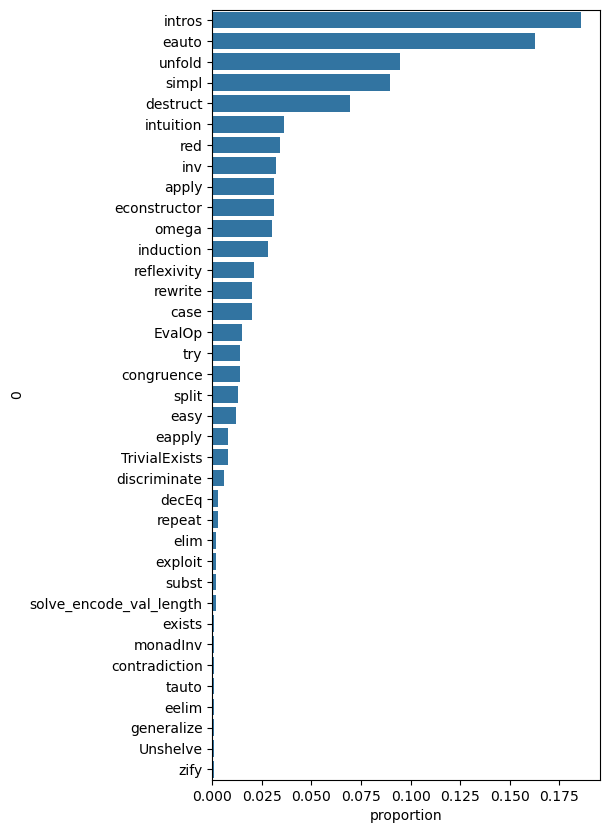

In [58]:
pred_tactics = tactics[idx[:, :, 'pred', :]]

plt.figure(figsize=(5, 10))
sns.countplot(data=pred_tactics.reset_index(drop=True), order=pred_tactics.value_counts().index, stat='proportion');

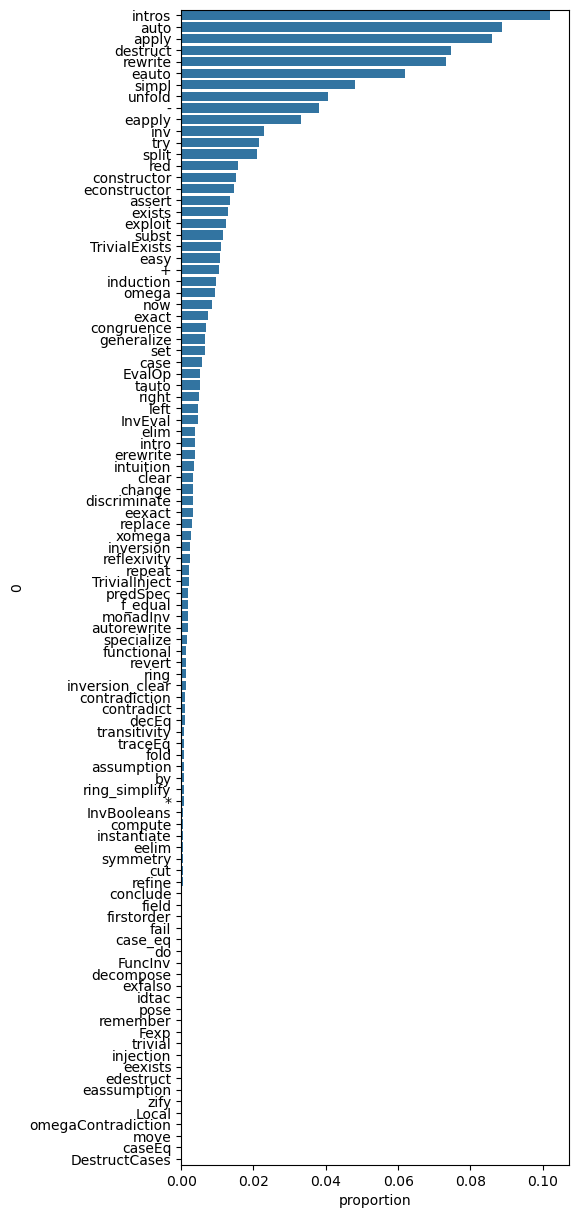

In [60]:
orig_tactics = tactics[idx[:, :, 'orig', :]]

plt.figure(figsize=(5, 15))
sns.countplot(data=orig_tactics.reset_index(drop=True), order=orig_tactics.value_counts().index, stat='proportion');